
# Importy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install sktime

Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


# Načtení a příprava dat

In [5]:
df =pd.read_csv("./smaller-labeled-dataset.csv",  header=None) # nrows=100,

In [6]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

In [7]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler, TimeSeriesScalerMinMax

In [8]:
p = df.values

In [9]:
(p.shape[1] - 22 - 2) / 12

501.0

In [10]:
nof_params = 22
nof_vars = 12
nof_samples = int((p.shape[1] - nof_params - 1)/ nof_vars)
pre_ts = p[:,nof_params:nof_params+nof_samples*nof_vars]
pre_ts /= pre_ts.max(axis=1)[:,None]
ts = np.reshape(pre_ts, (p.shape[0], nof_samples, nof_vars))[:,:,[5, 10]]

In [11]:
ts.shape

(70, 501, 2)

# Predikce

In [12]:
#for nof_clusters, gamma, max_iter in [(n, g, m) for n in [2,3,4,5,6] for g in range(0.1,1.0, 0.1) for m in [10, 20, 30, 40]]:
#  model = TimeSeriesKMeans(n_clusters=nof_clusters, metric="softdtw",
#                           metric_params={"gamma": gama},
#                           max_iter=max_iter, random_state=1234)
#  y_pred = model.fit_predict(X_train)
#  ... spocitas accuracy (znas jaky by to mal byt typ protoze to mas v tom pridanem sloupecku ;) a ulozis pro analyzu ...

In [13]:
from collections import Counter

In [47]:
#tvorba souboru s hlavickou pro ukladani vysledku
f = open('twenty-inits-69.csv', 'a')
f.write('max_iter, accuracy')
f.close()

In [48]:
with open('twenty-inits-69.csv', 'a') as f:
    X_train = TimeSeriesResampler(sz=100).fit_transform(ts)
    sz = X_train.shape[1]
    
    #print(np.any(np.isnan(X_train)))
    #print(np.any(np.isfinite(X_train)))

    nof_clusters = 7
    
    #nastaveni algoritmu klasterizace
    for max_iter in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        model = TimeSeriesKMeans(n_clusters=nof_clusters, metric="euclidean",
                               max_iter=max_iter, random_state=69,
                               n_jobs=-1, n_init=20)
        model.fit(X_train)
        y_pred = model.predict(X_train)

        #vypocet accuracy a mapovani
        classes = ['alergie', 'chronicka-nemoc', 'chronicky-zanet', 'neplausibilni', 'smrt-er', 'smrt-pato', 'vyleceno']
        cnt = 0 #pocitadlo
        clusters = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
        compar_types = []
        y_true = []
        y_true_in_clusters = []
        nof_occurences_classes = []
        nof_occurences = []

        #tvorba pole nami urcenych labelu - "spravna odpoved"
        for m in range(len(p)):
            y_true.append(p[m][-1])

        #tvorba pomocneho pole poli - labely prubehu zarazenych do jednotlivych klastru
        for i in range(nof_clusters):
            for j, idx in enumerate(np.where(y_pred == i)[0]): 
                compar_types.append(p[idx][-1])
            y_true_in_clusters.append(compar_types)
            compar_types = []

        #tvorba pole tuplu - v tuplu ulozen label a pole cetnosti jeho vyskytu v jednotlivych klastrech
        for k in classes:
            for l in y_true_in_clusters:
                nof_occurences.append(l.count(k))
            nof_occurences_classes.append((k, nof_occurences))
            nof_occurences = []

        #serazeni labelu podle maximalniho poctu vyskytu v klastru
        sorted_by_max = sorted(nof_occurences_classes, key=lambda x:max(x[1]), reverse=True)

        #mapovani - prirazovani labelu klastrum podle maximalniho mnozstvi vyskytu
        while 'x' in clusters:
            cand = sorted_by_max[0] #'kandidat' na prirazeni
            max_val = max(cand[1])
            idx = cand[1].index(max_val)
            if clusters[idx] == 'x': #dany klastr jeste nema label - priradime
                clusters[idx] = cand[0]
                del sorted_by_max[0]
            else: #dany klastr uz ma label - maximum nelze vyuzit, odstranime jej a pole pretridime s ohledem na nove maximum
                sorted_by_max[0][1][idx] = -1
                sorted_by_max = sorted(sorted_by_max, key=lambda x:max(x[1]), reverse=True)

        #transformace predpovezenych klastru z cisel do labelu dle vznikleho mapovani
        y_pred_class = []
        for i in y_pred:
            y_pred_class.append(clusters[i])

        #vypocet accuracy a zaznamenani vysledku
        acc_score = accuracy_score(y_true, y_pred_class)
        print(acc_score)
        f.write('\n')
        #f.write(str(gamma) + ', ' + str(max_iter) + ', ' + str(acc_score))
        f.write(str(max_iter) + ', ' + str(acc_score))
        f.flush()
    
#  ... spocitas accuracy (znas jaky by to mal byt typ protoze to mas v tom pridanem sloupecku ;) a ulozis pro analyzu ...

0.45714285714285713
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


In [15]:
#to samy jako v predchozi bunce, rozdil je v metrice - neni pak nutnost prepisovat jednu bunku mezi jednoduchymi 
# a slozitejsimi metrikami
with open('ten-inits.csv', 'a') as f:
    X_train = TimeSeriesResampler(sz=100).fit_transform(ts)
    sz = X_train.shape[1]

    nof_clusters = 7
    for gamma, max_iter in [(g, m) for g in np.arange(0.1, 1.0, 0.1) for m in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]:
        model = TimeSeriesKMeans(n_clusters=nof_clusters, metric="softdtw",
                               metric_params={"gamma": gamma},
                               max_iter=max_iter, random_state=1234,
                               n_jobs=-1, n_init=10)
        model.fit(X_train)
        y_pred = model.predict(X_train)

        #accuracy
        classes = ['alergie', 'chronicka-nemoc', 'chronicky-zanet', 'neplausibilni', 'smrt-er', 'smrt-pato', 'vyleceno']
        n = nof_clusters
        cnt = 0
        clusters = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
        compar_types = []
        y_true = []
        y_true_in_clusters = []
        nof_occurences_classes = []
        nof_occurences = []

        for m in range(len(p)):
            y_true.append(p[m][-1])

        for i in range(n):
            for j, idx in enumerate(np.where(y_pred == i)[0]): 
                compar_types.append(p[idx][-1])
            y_true_in_clusters.append(compar_types)
            compar_types = []
        
        for k in classes:
            for l in y_true_in_clusters:
                nof_occurences.append(l.count(k))
            nof_occurences_classes.append((k, nof_occurences))
            nof_occurences = []

        sorted_by_max = sorted(nof_occurences_classes, key=lambda x:max(x[1]), reverse=True)

        while 'x' in clusters:
            cand = sorted_by_max[0]
            max_val = max(cand[1])
            idx = cand[1].index(max_val)
            if clusters[idx] == 'x':
                clusters[idx] = cand[0]
                del sorted_by_max[0]
            else:
                sorted_by_max[0][1][idx] = -1
                sorted_by_max = sorted(sorted_by_max, key=lambda x:max(x[1]), reverse=True)

        y_pred_class = []
        for i in y_pred:
            y_pred_class.append(clusters[i])

        acc_score = accuracy_score(y_true, y_pred_class)
        print(acc_score)
        f.write('\n')
        f.write(str(gamma) + ', ' + str(max_iter) + ', ' + str(acc_score))
        #f.write(str(max_iter) + ', ' + str(acc_score))
        f.flush()
    
#  ... spocitas accuracy (znas jaky by to mal byt typ protoze to mas v tom pridanem sloupecku ;) a ulozis pro analyzu ...

0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.4857142857142857
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.5285714285714286
0.4714285714285714
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5571428571428572
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.45714285714285713
0.45714285714285713
0.45714285714285713
0.45714285714285713
0.45714285714285713
0.457

In [18]:
X_train.shape

(70, 100, 2)

In [30]:
from collections import Counter

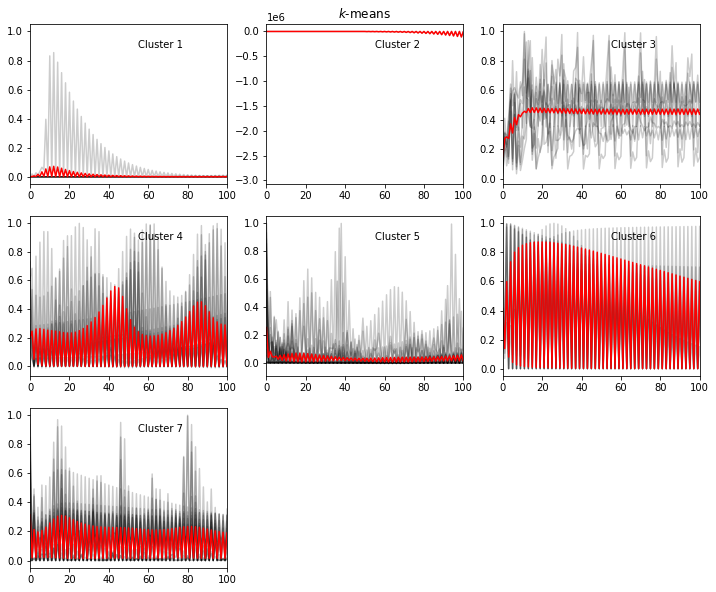

In [18]:
km = model
plt.figure(figsize=(12,10))
for yi in range(nof_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("$k$-means")

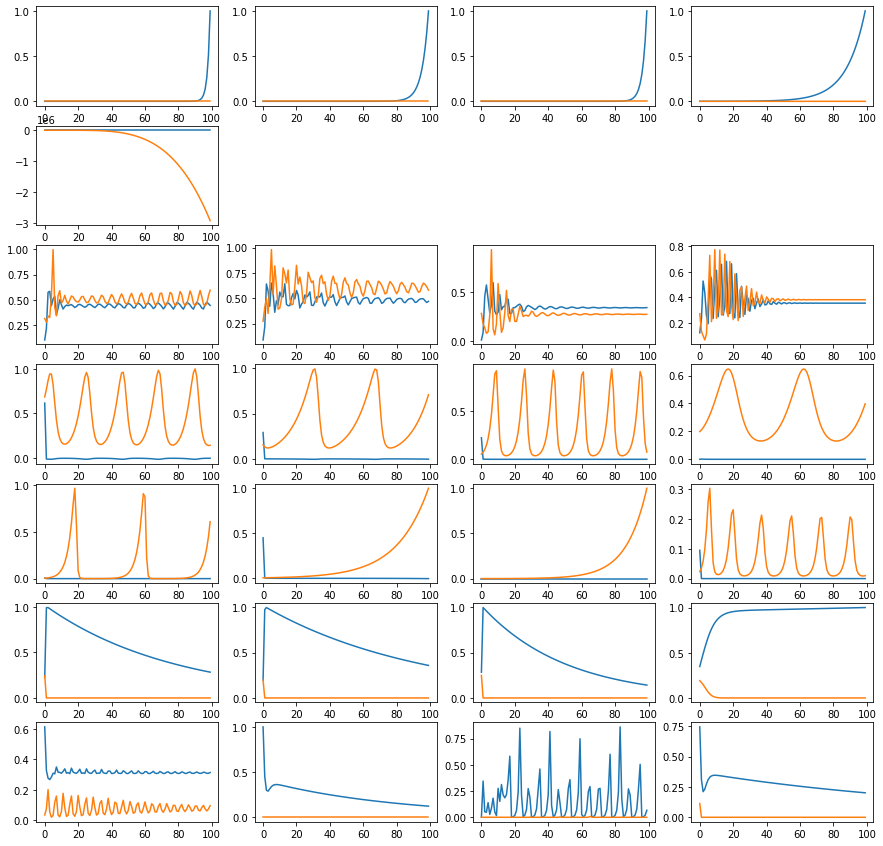

In [19]:
n = nof_clusters
nn = 4 #tolikrat probehne vnitrni cyklus

plt.figure(figsize=(15,15))

for i in range(n):
    sims_in_cluster = []
    for j, idx in enumerate(np.where(y_pred == i)[0]): 
        #prochazi veci v tride
        #np.where vyplivne indexy kde plati podminka
        sims_in_cluster.append(idx)
        
    for k in range(nn):
        if len(sims_in_cluster) == 0:
            break
        else:
            chosen = random.choice(sims_in_cluster)
            plt.subplot(n, nn, nn*i+k+1)
            plt.plot(X_train[chosen,:,:])
            sims_in_cluster.remove(chosen)


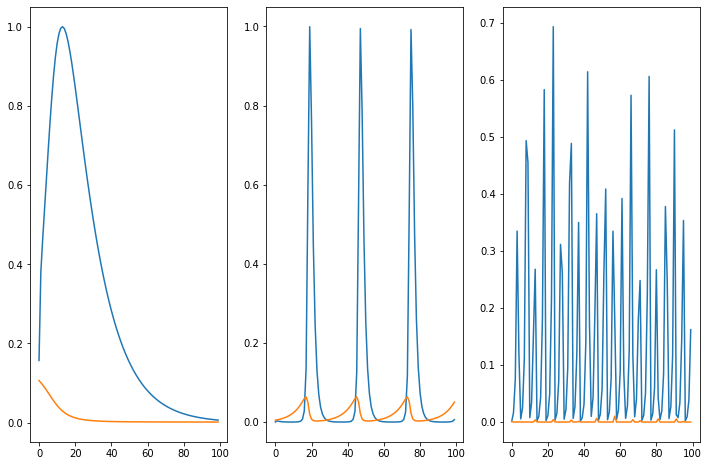

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(1, 3, 1)
plt.plot(X_train[0,:,:])
plt.subplot(1, 3, 2)
plt.plot(X_train[1,:,:])
plt.subplot(1, 3, 3)
plt.plot(X_train[2,:,:])


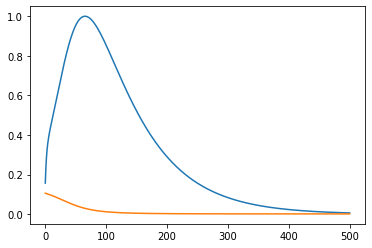

In [21]:
plt.plot(ts[0,:,:])

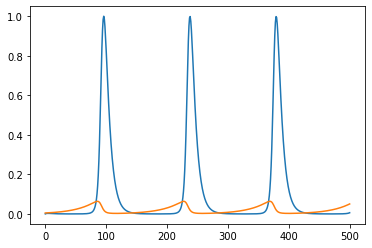

In [22]:
plt.plot(ts[1,:,:])

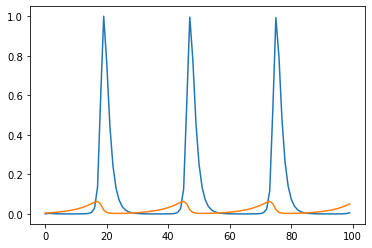

In [23]:
plt.plot(X_train[1,:,:])